# Aplicación de Transfer Learning

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
!pip install torchinfo

## Conjunto de datos a usar: 
https://www.kaggle.com/datasets/jay7080dev/rice-plant-diseases-dataset

In [41]:
import torch
import torchvision
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
from torchinfo import summary
from torch.utils.data import DataLoader,TensorDataset,Dataset

import dl_disease #Este código lo crea el GUI generador de Dataset
from helper_evaluation import compute_accuracy
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy

In [42]:
BATCH_SIZE = 32

### Crear Dataset con el código creado

In [43]:
Dataset = dl_disease.ImageDataset()

In [44]:
print(len(Dataset))
l_ds = len(Dataset)

#Dividir el conjunto de datos en entrenamiento/validación/test
l_tr = int(round(l_ds*0.8))
l_valtest = int(l_ds - l_tr)

l_val = int(l_valtest*0.5)
l_test = int(l_valtest - l_val)


3898


In [45]:
train_set, val_set = torch.utils.data.random_split(Dataset,[l_tr,l_valtest])
val_set, test_set = torch.utils.data.random_split(val_set,
                                                  [l_val, l_test])


In [46]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

3118
390
390


In [47]:
train_iterator = DataLoader(train_set,
                            batch_size = BATCH_SIZE, 
                            shuffle = True, 
                            num_workers = 2)

val_iterator = DataLoader(val_set,
                          batch_size = BATCH_SIZE)

test_iterator = DataLoader(test_set,
                           batch_size = BATCH_SIZE)

In [48]:
it_dl = iter(train_iterator)

In [49]:
image, label = next(it_dl)

In [50]:
print(image.shape)
print(label)

torch.Size([32, 1, 32, 32])
tensor([0, 2, 0, 2, 0, 1, 0, 2, 1, 2, 0, 2, 0, 0, 1, 1, 1, 2, 1, 1, 1, 2, 0, 2,
        0, 1, 0, 1, 0, 1, 0, 1])


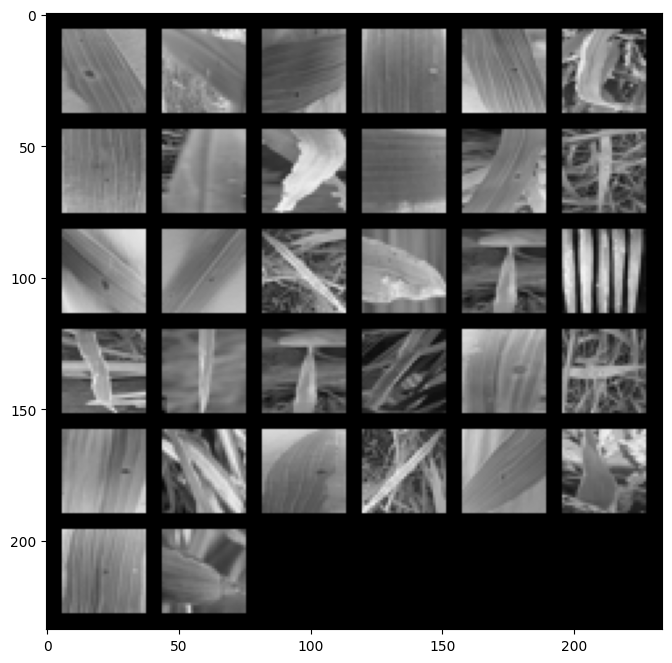

In [51]:
grid = torchvision.utils.make_grid(image, 6, 6)
plt.figure(figsize=(8,8))
plt.imshow(F.to_pil_image(grid))

In [52]:
for images, labels in train_iterator:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 32, 32])
Image label dimensions: torch.Size([32])


## Transfer Learning: Usar modelos preentrenados

In [53]:
!pip install timm

In [54]:
import timm

In [55]:
# all_models = timm.list_models('mob*')
all_models = timm.list_models('eff*')
len(all_models)
all_models

['efficientformer_l1',
 'efficientformer_l3',
 'efficientformer_l7',
 'efficientformerv2_l',
 'efficientformerv2_s0',
 'efficientformerv2_s1',
 'efficientformerv2_s2',
 'efficientnet_b0',
 'efficientnet_b0_g8_gn',
 'efficientnet_b0_g16_evos',
 'efficientnet_b0_gn',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b3',
 'efficientnet_b3_g8_gn',
 'efficientnet_b3_gn',
 'efficientnet_b3_pruned',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t',
 'e

In [56]:
model = timm.create_model('mobilenetv3_small_050', 
                          num_classes = 3, 
                          pretrained = True,
                          in_chans = 1)

In [57]:
model

MobileNetV3(
  (conv_stem): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): ReLU(inplace=True)
          (conv_expand): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (gate): Hardsigmoid()
        )
        (conv_pw): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          8

In [58]:
summary(model, (32, 1, 32, 32))

Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV3                                   [32, 3]                   --
├─Conv2d: 1-1                                 [32, 16, 16, 16]          144
├─BatchNormAct2d: 1-2                         [32, 16, 16, 16]          32
│    └─Identity: 2-1                          [32, 16, 16, 16]          --
│    └─Hardswish: 2-2                         [32, 16, 16, 16]          --
├─Sequential: 1-3                             [32, 288, 1, 1]           --
│    └─Sequential: 2-3                        [32, 8, 8, 8]             --
│    │    └─DepthwiseSeparableConv: 3-1       [32, 8, 8, 8]             600
│    └─Sequential: 2-4                        [32, 16, 4, 4]            --
│    │    └─InvertedResidual: 3-2             [32, 16, 4, 4]            1,512
│    │    └─InvertedResidual: 3-3             [32, 16, 4, 4]            2,552
│    └─Sequential: 2-5                        [32, 24, 2, 2]            --
│    │    └─

### Uso del modelo

In [59]:
x = torch.randn(2, 1, 32, 32)
model(x).shape

torch.Size([2, 3])

In [60]:
model(x)

tensor([[  4.3866,  -7.9872, -15.5131],
        [ -2.9339,  14.1226,   2.0456]], grad_fn=<AddmmBackward0>)

In [61]:
torch.nn.functional.softmax(model(x), dim=-1)

tensor([[1.0000e+00, 4.2277e-06, 2.2785e-09],
        [3.9126e-08, 9.9999e-01, 5.6891e-06]], grad_fn=<SoftmaxBackward0>)

In [62]:
NUM_EPOCHS = 100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Resultado de modelo preentrenado

In [63]:
compute_accuracy(model, test_iterator, DEVICE)

tensor(44.6154)

## Congelar parámetros menos FC

In [64]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv_stem.weight True
bn1.weight True
bn1.bias True
blocks.0.0.conv_dw.weight True
blocks.0.0.bn1.weight True
blocks.0.0.bn1.bias True
blocks.0.0.se.conv_reduce.weight True
blocks.0.0.se.conv_reduce.bias True
blocks.0.0.se.conv_expand.weight True
blocks.0.0.se.conv_expand.bias True
blocks.0.0.conv_pw.weight True
blocks.0.0.bn2.weight True
blocks.0.0.bn2.bias True
blocks.1.0.conv_pw.weight True
blocks.1.0.bn1.weight True
blocks.1.0.bn1.bias True
blocks.1.0.conv_dw.weight True
blocks.1.0.bn2.weight True
blocks.1.0.bn2.bias True
blocks.1.0.conv_pwl.weight True
blocks.1.0.bn3.weight True
blocks.1.0.bn3.bias True
blocks.1.1.conv_pw.weight True
blocks.1.1.bn1.weight True
blocks.1.1.bn1.bias True
blocks.1.1.conv_dw.weight True
blocks.1.1.bn2.weight True
blocks.1.1.bn2.bias True
blocks.1.1.conv_pwl.weight True
blocks.1.1.bn3.weight True
blocks.1.1.bn3.bias True
blocks.2.0.conv_pw.weight True
blocks.2.0.bn1.weight True
blocks.2.0.bn1.bias True
blocks.2.0.conv_dw.weight True
blocks.2.0.bn2.weigh

In [65]:
for param in model.parameters():
    param.requires_grad = False

In [66]:
model.classifier.weight.requires_grad = True
model.classifier.bias.requires_grad = True

In [67]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv_stem.weight False
bn1.weight False
bn1.bias False
blocks.0.0.conv_dw.weight False
blocks.0.0.bn1.weight False
blocks.0.0.bn1.bias False
blocks.0.0.se.conv_reduce.weight False
blocks.0.0.se.conv_reduce.bias False
blocks.0.0.se.conv_expand.weight False
blocks.0.0.se.conv_expand.bias False
blocks.0.0.conv_pw.weight False
blocks.0.0.bn2.weight False
blocks.0.0.bn2.bias False
blocks.1.0.conv_pw.weight False
blocks.1.0.bn1.weight False
blocks.1.0.bn1.bias False
blocks.1.0.conv_dw.weight False
blocks.1.0.bn2.weight False
blocks.1.0.bn2.bias False
blocks.1.0.conv_pwl.weight False
blocks.1.0.bn3.weight False
blocks.1.0.bn3.bias False
blocks.1.1.conv_pw.weight False
blocks.1.1.bn1.weight False
blocks.1.1.bn1.bias False
blocks.1.1.conv_dw.weight False
blocks.1.1.bn2.weight False
blocks.1.1.bn2.bias False
blocks.1.1.conv_pwl.weight False
blocks.1.1.bn3.weight False
blocks.1.1.bn3.bias False
blocks.2.0.conv_pw.weight False
blocks.2.0.bn1.weight False
blocks.2.0.bn1.bias False
blocks.2.0.conv_d

In [68]:
summary(model, (32,1, 32, 32))


Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV3                                   [32, 3]                   --
├─Conv2d: 1-1                                 [32, 16, 16, 16]          (144)
├─BatchNormAct2d: 1-2                         [32, 16, 16, 16]          32
│    └─Identity: 2-1                          [32, 16, 16, 16]          --
│    └─Hardswish: 2-2                         [32, 16, 16, 16]          --
├─Sequential: 1-3                             [32, 288, 1, 1]           --
│    └─Sequential: 2-3                        [32, 8, 8, 8]             --
│    │    └─DepthwiseSeparableConv: 3-1       [32, 8, 8, 8]             (600)
│    └─Sequential: 2-4                        [32, 16, 4, 4]            --
│    │    └─InvertedResidual: 3-2             [32, 16, 4, 4]            (1,512)
│    │    └─InvertedResidual: 3-3             [32, 16, 4, 4]            (2,552)
│    └─Sequential: 2-5                        [32, 24, 2, 2]            --
│   

In [69]:
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_iterator,
    valid_loader=val_iterator,
    test_loader=test_iterator,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=70)

/home/andrescastro/miniconda3/envs/Pytorch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 001/100 | Batch 0000/0098 | Loss: 8.0719
Epoch: 001/100 | Batch 0070/0098 | Loss: 6.4235
Epoch: 001/100 | Train: 61.90% | Validation: 59.74%
Time elapsed: 0.13 min
Epoch: 002/100 | Batch 0000/0098 | Loss: 9.3027
Epoch: 002/100 | Batch 0070/0098 | Loss: 6.5430
Epoch: 002/100 | Train: 69.63% | Validation: 70.51%
Time elapsed: 0.26 min
Epoch: 003/100 | Batch 0000/0098 | Loss: 4.7166
Epoch: 003/100 | Batch 0070/0098 | Loss: 4.2779
Epoch: 003/100 | Train: 73.83% | Validation: 72.82%
Time elapsed: 0.40 min
Epoch: 004/100 | Batch 0000/0098 | Loss: 3.0510
Epoch: 004/100 | Batch 0070/0098 | Loss: 2.2544
Epoch: 004/100 | Train: 71.26% | Validation: 67.18%
Time elapsed: 0.54 min
Epoch: 005/100 | Batch 0000/0098 | Loss: 4.5133
Epoch: 005/100 | Batch 0070/0098 | Loss: 3.4420
Epoch: 005/100 | Train: 74.92% | Validation: 73.85%
Time elapsed: 0.69 min
Epoch: 006/100 | Batch 0000/0098 | Loss: 3.3935
Epoch: 006/100 | Batch 0070/0098 | Loss: 1.4744
Epoch: 006/100 | Train: 77.84% | Validation: 73.3

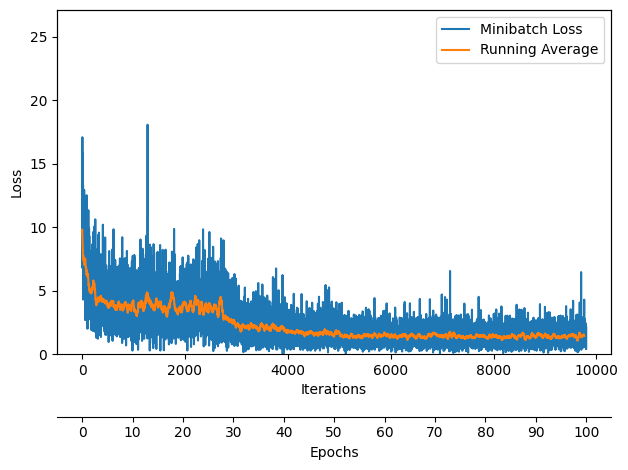

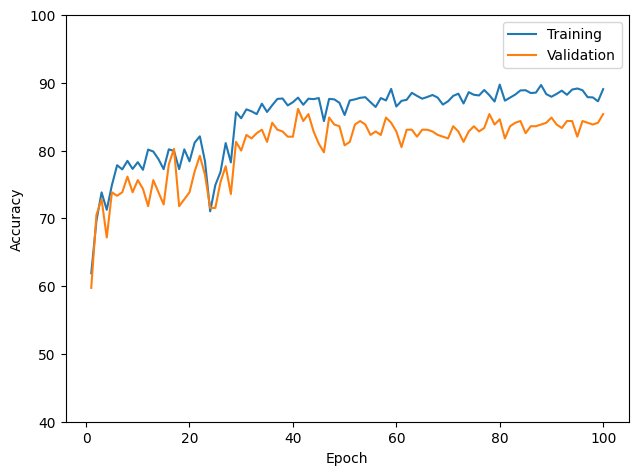

In [70]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_iterator),
                   results_dir=None,
                   averaging_iterations=40)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([40, 100])
plt.show()

In [71]:
compute_accuracy(model, test_iterator, DEVICE)

tensor(83.0769)

## Entrenar modelo completo

In [72]:
model = timm.create_model('mobilenetv3_small_050', 
                          num_classes = 3, 
                          pretrained = True,
                          in_chans = 1)

In [73]:
for param in model.parameters():
    print(param.requires_grad,end=' ')

True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True 

In [74]:
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_iterator,
    valid_loader=val_iterator,
    test_loader=test_iterator,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=70)

/home/andrescastro/miniconda3/envs/Pytorch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 001/100 | Batch 0000/0098 | Loss: 20.0084
Epoch: 001/100 | Batch 0070/0098 | Loss: 1.3740
Epoch: 001/100 | Train: 47.02% | Validation: 47.44%
Time elapsed: 0.63 min
Epoch: 002/100 | Batch 0000/0098 | Loss: 1.1029
Epoch: 002/100 | Batch 0070/0098 | Loss: 0.9480
Epoch: 002/100 | Train: 61.61% | Validation: 57.95%
Time elapsed: 1.13 min
Epoch: 003/100 | Batch 0000/0098 | Loss: 1.0261
Epoch: 003/100 | Batch 0070/0098 | Loss: 1.0719
Epoch: 003/100 | Train: 67.67% | Validation: 66.41%
Time elapsed: 1.35 min
Epoch: 004/100 | Batch 0000/0098 | Loss: 0.8233
Epoch: 004/100 | Batch 0070/0098 | Loss: 1.1412
Epoch: 004/100 | Train: 70.14% | Validation: 65.64%
Time elapsed: 1.62 min
Epoch: 005/100 | Batch 0000/0098 | Loss: 0.5400
Epoch: 005/100 | Batch 0070/0098 | Loss: 0.9994
Epoch: 005/100 | Train: 70.72% | Validation: 64.87%
Time elapsed: 2.13 min
Epoch: 006/100 | Batch 0000/0098 | Loss: 0.5239
Epoch: 006/100 | Batch 0070/0098 | Loss: 1.0477
Epoch: 006/100 | Train: 73.19% | Validation: 67.

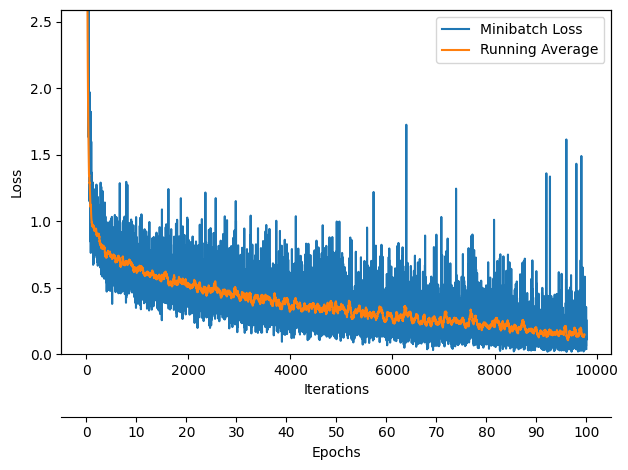

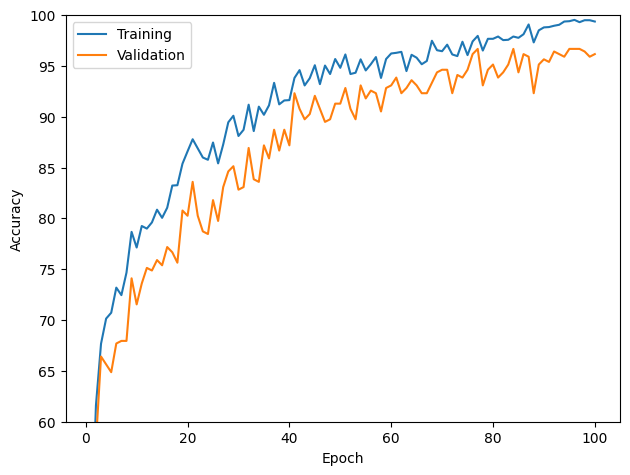

In [75]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_iterator),
                   results_dir=None,
                   averaging_iterations=40)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

In [76]:
compute_accuracy(model, test_iterator, DEVICE)

tensor(96.4103)